# Dutch House Price Prediction using XGBoost



In this notebook, I will analyze the Funda.nl housing dataset to gain insightful information and build a predictive model using XGBoost to estimate house prices.

I will start by importing the necessary libraries for data manipulation, visualization, and modeling.

In [ ]:
from scipy.stats import skew
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## EDA

The first step in the modeling process will be exploring the dataset. In this section I will load the data, examine its structure, and perform initial visualizations to understand the underlying patterns and relationships.

In [ ]:
# Loading data with pandas
path = 'Funda_dataset_cleaned.csv'
data = pd.read_csv(path)

# Displaying information about the dataset
print(data.info())
print(data.shape)

# Displaying the first few rows of the dataset
print(data.head())

# Descriptive statistics of the dataset
print(data.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9884 entries, 0 to 9883
Columns: 112 entries, Aangeboden sinds to Soort woonhuis
dtypes: int64(104), object(8)
memory usage: 8.4+ MB
None
(9884, 112)
  Aangeboden sinds Verkoopdatum  Laatste vraagprijs    Status Soort bouw  \
0       2022-05-19   2023-03-10              485000  Verkocht  Nieuwbouw   
1       2022-09-26   2023-06-22              375000  Verkocht  Nieuwbouw   
2       2023-01-25   2023-05-18              279500  Verkocht  Nieuwbouw   
3       2022-12-02   2023-05-09             2330000  Verkocht  Nieuwbouw   
4       2022-12-02   2023-05-15             2270000  Verkocht  Nieuwbouw   

   Aantal kamers Energielabel  Overige inpandige ruimte m2  Perceel m2  \
0              5            A                           18         263   
1              5         A+++                            0         198   
2              3          NaN                            4         128   
3              8          NaN                  

The predictions will be based on property features only, excluding non-numeric data such as 'listing post', 'status', and 'time-series'. Therefore, I will remove columns like 'Offered since' and 'Sale date'. As the dataset is rich in other features, this will not impact the analysis.

Additionaly, in this project, I performed Exploratory Data Analysis (EDA) on a numerical version of the dataset. This step was crucial for conducting correlation analysis and creating heatmaps, which require numeric data to provide meaningful insights. By converting the dataset to a purely numerical form, I was able to explore relationships and patterns within the data effectively.

In [ ]:
data.drop(['Aangeboden sinds', 'Verkoopdatum'], axis=1, inplace=True)
numeric_data = data.select_dtypes(include=[np.number])
numeric_data

,Laatste vraagprijs,Aantal kamers,Overige inpandige ruimte m2,Perceel m2,Achtertuin m2,Vraagprijs per m2,Woonruimte in m2,Gebouwgebonden buitenruimte in m2,Externe bergruimte in m2,Inhoud in m3,...,Soort garage_Parkeerplaats,Soort garage_Inpandig,Soort garage_Parkeerkelder,Soort garage_Garagebox,Soort garage_Aangebouwdestenen garage,Soort garage_Carport,Soort garage_Vrijstaandestenen garage,Soort garage_Vrijstaandehouten garage,Soort garage_Garagemet carport,Soort garage_Souterrain
0,485000,5,18,263,120,3212,151,0,0,625,...,0,0,0,0,0,0,0,0,0,0
1,375000,5,0,198,60,3205,117,0,5,415,...,1,0,0,0,0,0,0,0,0,0
2,279500,3,4,128,68,2973,94,0,0,365,...,0,0,0,0,0,0,0,0,0,0
3,2330000,8,0,2479,2172,7590,307,0,0,921,...,1,0,0,0,0,0,0,0,0,0
4,2270000,8,0,1796,1489,7394,307,0,0,921,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9879,494449,6,16,653,477,3296,150,4,22,646,...,1,0,0,0,0,0,1,0,0,0
9880,425000,5,61,356,75,3899,109,0,0,619,...,0,1,0,0,0,0,0,0,0,0
9881,279500,4,10,119,30,2117,132,8,0,540,...,0,0,0,0,0,0,0,0,0,0
9882,365000,5,0,178,63,3093,118,13,8,405,...,0,0,0,0,0,0,0,0,0,0


Next, I will check for correlations between features to understand their relationships and identify any multicollinearity issues. This will help in selecting the most relevant features for the model.



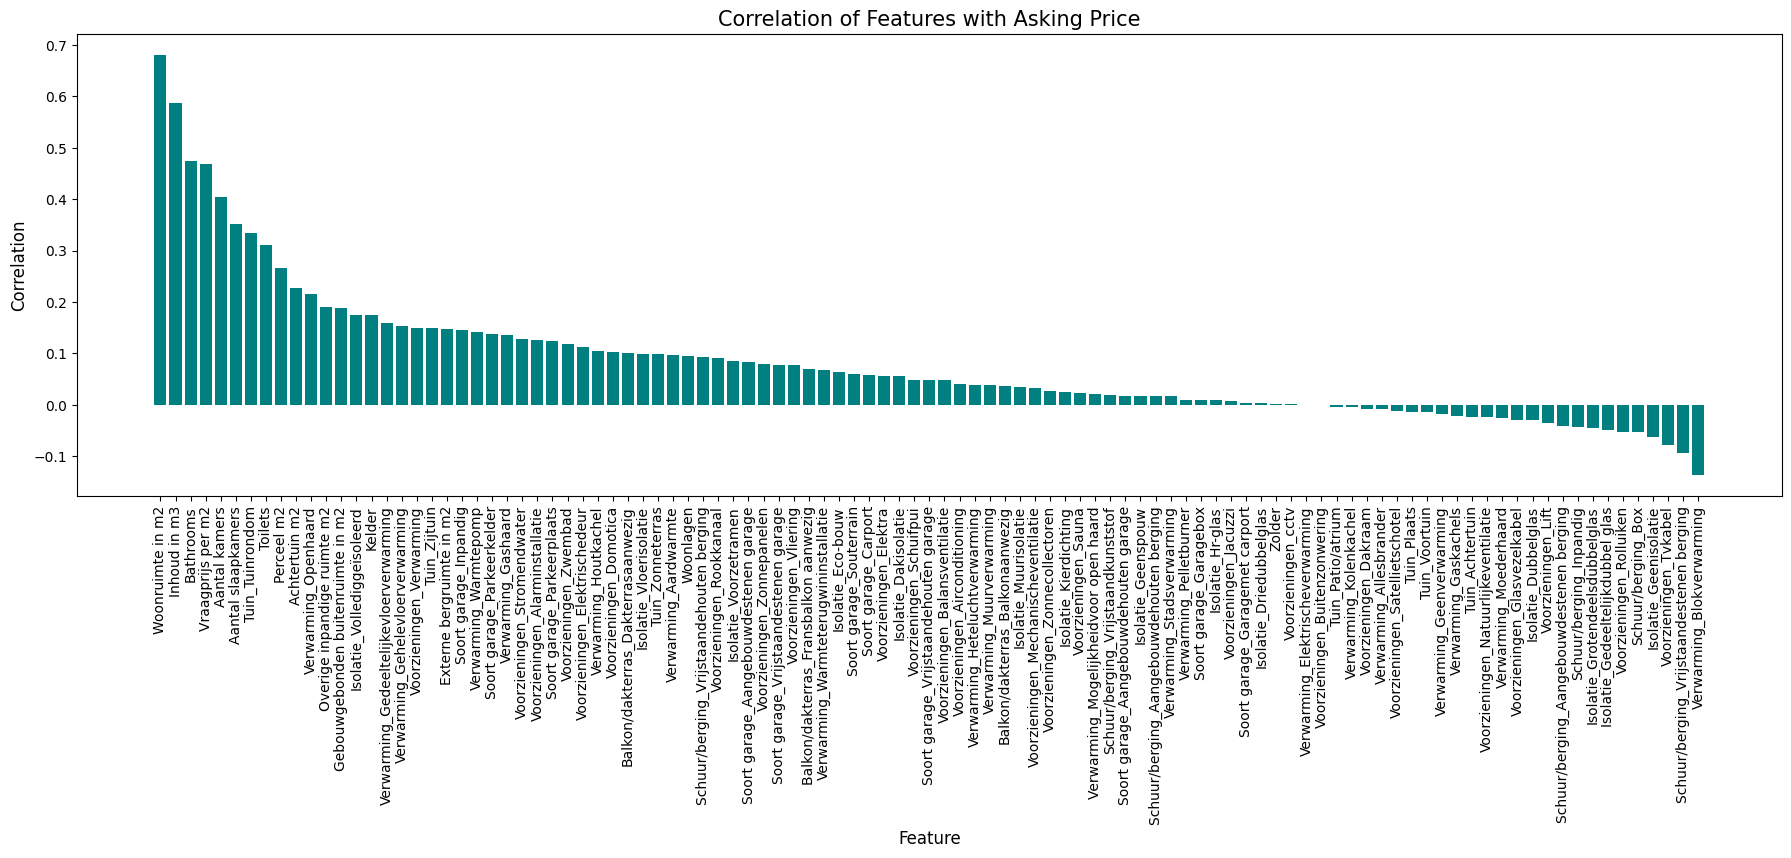

In [ ]:
numeric_data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs')
cor=numeric_data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs')
plt.figure(figsize=(22,6))
plt.bar(x=list(cor.index), height=list(cor.values), color='teal')
plt.xticks(rotation=90)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Correlation', fontsize=12)
plt.title('Correlation of Features with Asking Price', fontsize=15)
plt.show()


As there are too many features, it will be important to perform feature selection to reduce computation time and analyze the relationships more effectively. This will be further explained in later sections

Now, I will check for skewness of target variable

Text(0.5, 1.0, 'Distribution of Laatste vraagprijs')

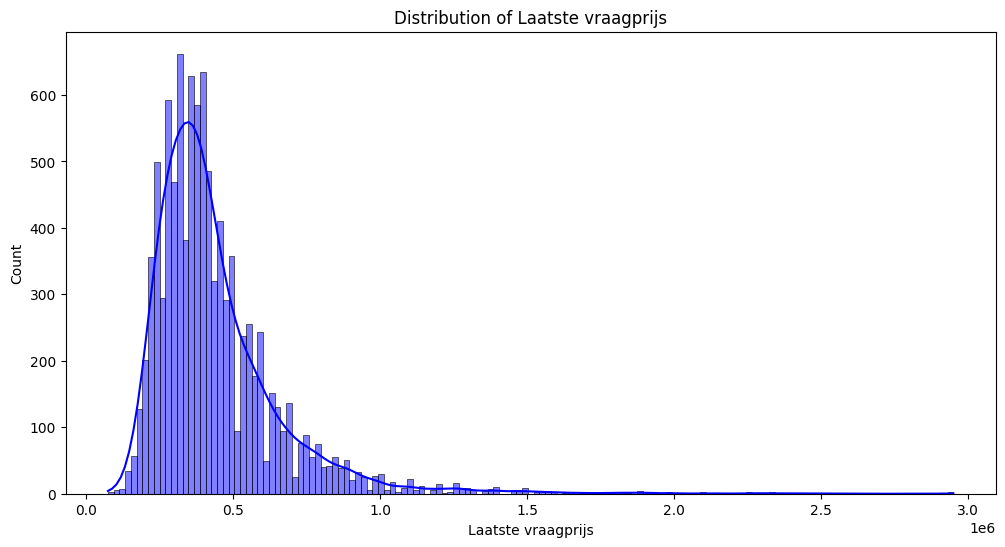

In [ ]:
# Target variable
column_of_interest = 'Laatste vraagprijs'

#  skewness before log transformation
skewness_before = skew(data[column_of_interest])

# Distribution before log transformation
plt.figure(figsize=(12, 6))
sns.histplot(data[column_of_interest].dropna(), kde=True, color='blue', bins='auto')
plt.title(f'Distribution of {column_of_interest}')


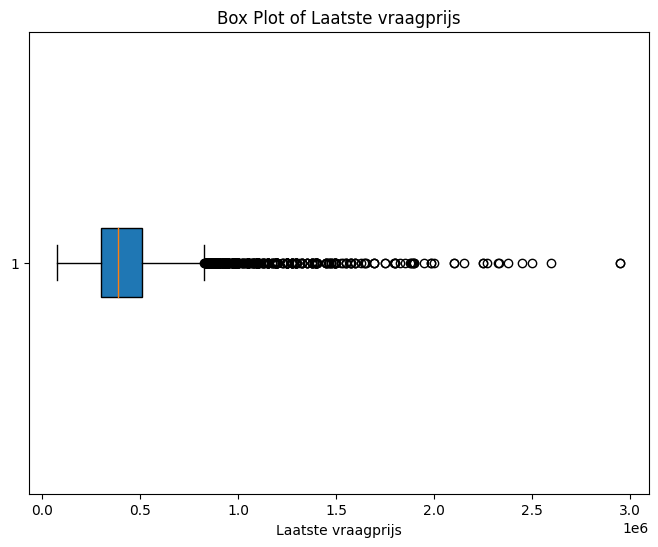

In [ ]:
# Box plot of the target variable
X = numeric_data.drop('Laatste vraagprijs', axis=1)
y = numeric_data['Laatste vraagprijs']

# Box plot for the target variable with color
plt.figure(figsize=(8, 6))
box = plt.boxplot(y, vert=False, patch_artist=True)
plt.title('Box Plot of Laatste vraagprijs')
plt.xlabel('Laatste vraagprijs')

plt.show()

As we see, the target variable last asking price has a long tail to the right of the x-axis, meaning the variable is right-skewed. In the preprocessing stage this skewness will be handled.

## Data Cleaning and Preprocessing

As we have a brief overview of the dataset, we can start with cleaning process. The dataset at hand comes cleaned, therefore in this stage I will take small steps for cleaning, I will also do feature selection, outlier detection, scaling and skewness handling.

In [ ]:
# Counting missing values in each column
missing_values_count = numeric_data.isnull().sum()

# Printing number of missing values in each column
print(missing_values_count)

# Count and display the number of duplicate rows before dropping
num_duplicates = data.duplicated().sum()
print("Number of duplicate rows:", num_duplicates)

numeric_data.drop_duplicates(inplace=True)

# Count and display the number of duplicate rows after dropping
num_duplicates_after = numeric_data.duplicated().sum()
print("Number of duplicate rows after dropping:", num_duplicates_after)


Laatste vraagprijs                       0
Aantal kamers                            0
Overige inpandige ruimte m2              0
Perceel m2                               0
Achtertuin m2                            0
                                        ..
Soort garage_Carport                     0
Soort garage_Vrijstaandestenen garage    0
Soort garage_Vrijstaandehouten garage    0
Soort garage_Garagemet carport           0
Soort garage_Souterrain                  0
Length: 104, dtype: int64
Number of duplicate rows: 13
Number of duplicate rows after dropping: 0


For this particular prediction, I will conduct Feature Selection by removing the features that has less than 0.1 correlation with the target variable. The goal is to reduce computation time, remove redundant features and have cleaner data.

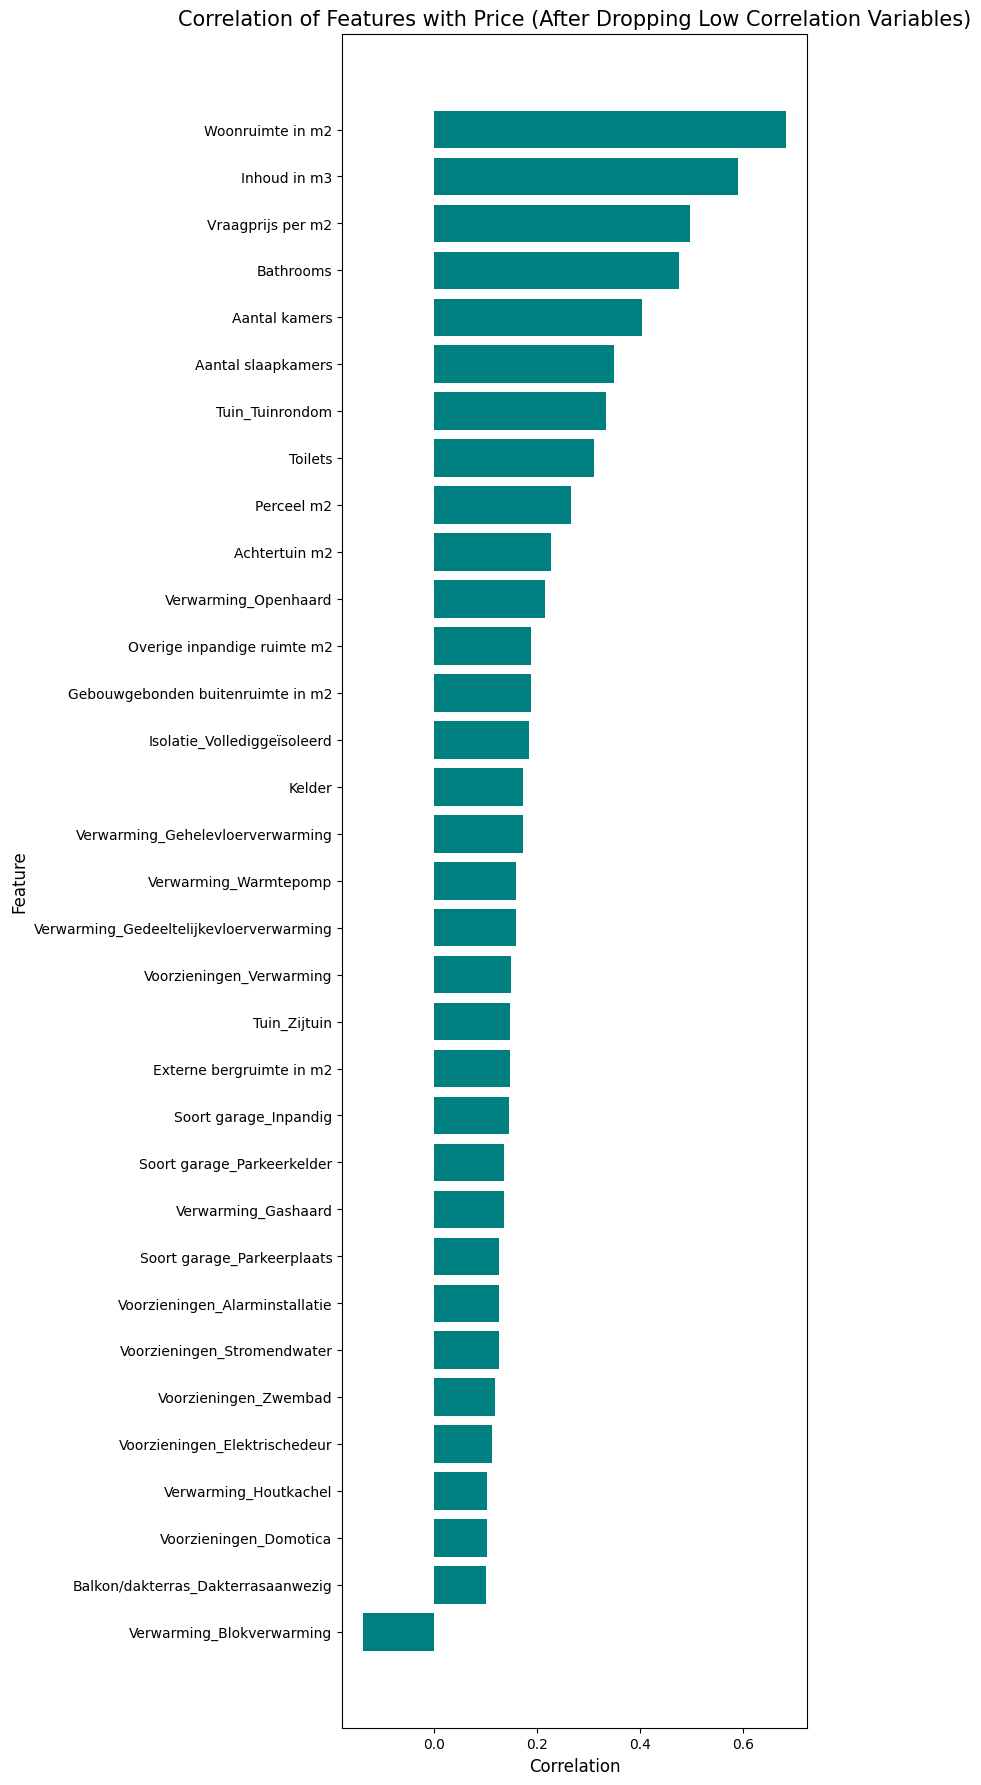


Number of features after feature selection: 34


In [ ]:
# Calculate the correlation matrix
corr_matrix = numeric_data.corr()

# Select the variables that have a correlation less than 0.1 with the target variable
drop_list = corr_matrix[corr_matrix['Laatste vraagprijs'].abs() < 0.1].index.to_list()

# Drop the variables from the data and assign it back to numeric_data
numeric_data = numeric_data.drop(drop_list, axis=1)

# Plot the correlation matrix of the remaining variables vertically with highest correlation on top
plt.figure(figsize=(6, 22))
sorted_features = numeric_data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs')
plt.barh(y=sorted_features.index[::-1], width=sorted_features.values[::-1], color='teal')  # Reverse the order
plt.ylabel('Feature', fontsize=12)  # Change to ylabel
plt.xlabel('Correlation', fontsize=12)  # Change to xlabel
plt.title('Correlation of Features with Price (After Dropping Low Correlation Variables)', fontsize=15)
plt.show()


print("\nNumber of features after feature selection:", numeric_data.shape[1])


By doing so, I have reduced the number of columns to 33, making it easy to analyze and work with more relevant features. It's important to note that this feature selection process is specific to this project and dataset. Removing correlated features with less than 0.1 correlation may not always be a universally good idea, as its effectiveness can vary depending on the dataset and the specific problem being addressed.

For outlier detection, Z-scores are calculated for each numeric column in the dataset using the scipy library. A threshold of 3 standard deviations is defined, and any data point with a Z-score exceeding this threshold is considered an outlier. However, I won't handle outliers in this project since the XGBoost model is known to be robust to outliers.

In [ ]:
from scipy import stats

# Calculate the number of outliers per column
outliers_per_column = {}

# Iterate over each column
for column in numeric_data.columns:
    # Calculate Z-scores for the current column
    z_scores_column = stats.zscore(numeric_data[column])
    # Define a threshold for Z-score
    threshold = 3
    # Find and count the outliers
    outliers_count = (z_scores_column > threshold).sum()
    # Store the number of outliers for the current column
    outliers_per_column[column] = outliers_count

# Print the number of outliers per column
print("Number of outliers per column:")
for column, count in outliers_per_column.items():
    print(f"{column}: {count}")


Number of outliers per column:
Laatste vraagprijs: 169
Aantal kamers: 103
Overige inpandige ruimte m2: 95
Perceel m2: 81
Achtertuin m2: 74
Vraagprijs per m2: 234
Woonruimte in m2: 134
Gebouwgebonden buitenruimte in m2: 104
Externe bergruimte in m2: 106
Inhoud in m3: 119
Aantal slaapkamers: 32
Bathrooms: 59
Toilets: 892
Kelder: 644
Voorzieningen_Domotica: 18
Voorzieningen_Zwembad: 20
Voorzieningen_Verwarming: 644
Voorzieningen_Stromendwater: 0
Voorzieningen_Elektrischedeur: 552
Voorzieningen_Alarminstallatie: 49
Isolatie_Vollediggeïsoleerd: 0
Verwarming_Gedeeltelijkevloerverwarming: 0
Verwarming_Warmtepomp: 682
Verwarming_Gehelevloerverwarming: 768
Verwarming_Blokverwarming: 400
Verwarming_Gashaard: 242
Verwarming_Openhaard: 305
Verwarming_Houtkachel: 374
Balkon/dakterras_Dakterrasaanwezig: 644
Tuin_Zijtuin: 0
Tuin_Tuinrondom: 706
Soort garage_Parkeerplaats: 801
Soort garage_Inpandig: 472
Soort garage_Parkeerkelder: 340


Let's analyze the relation with a heat map as well

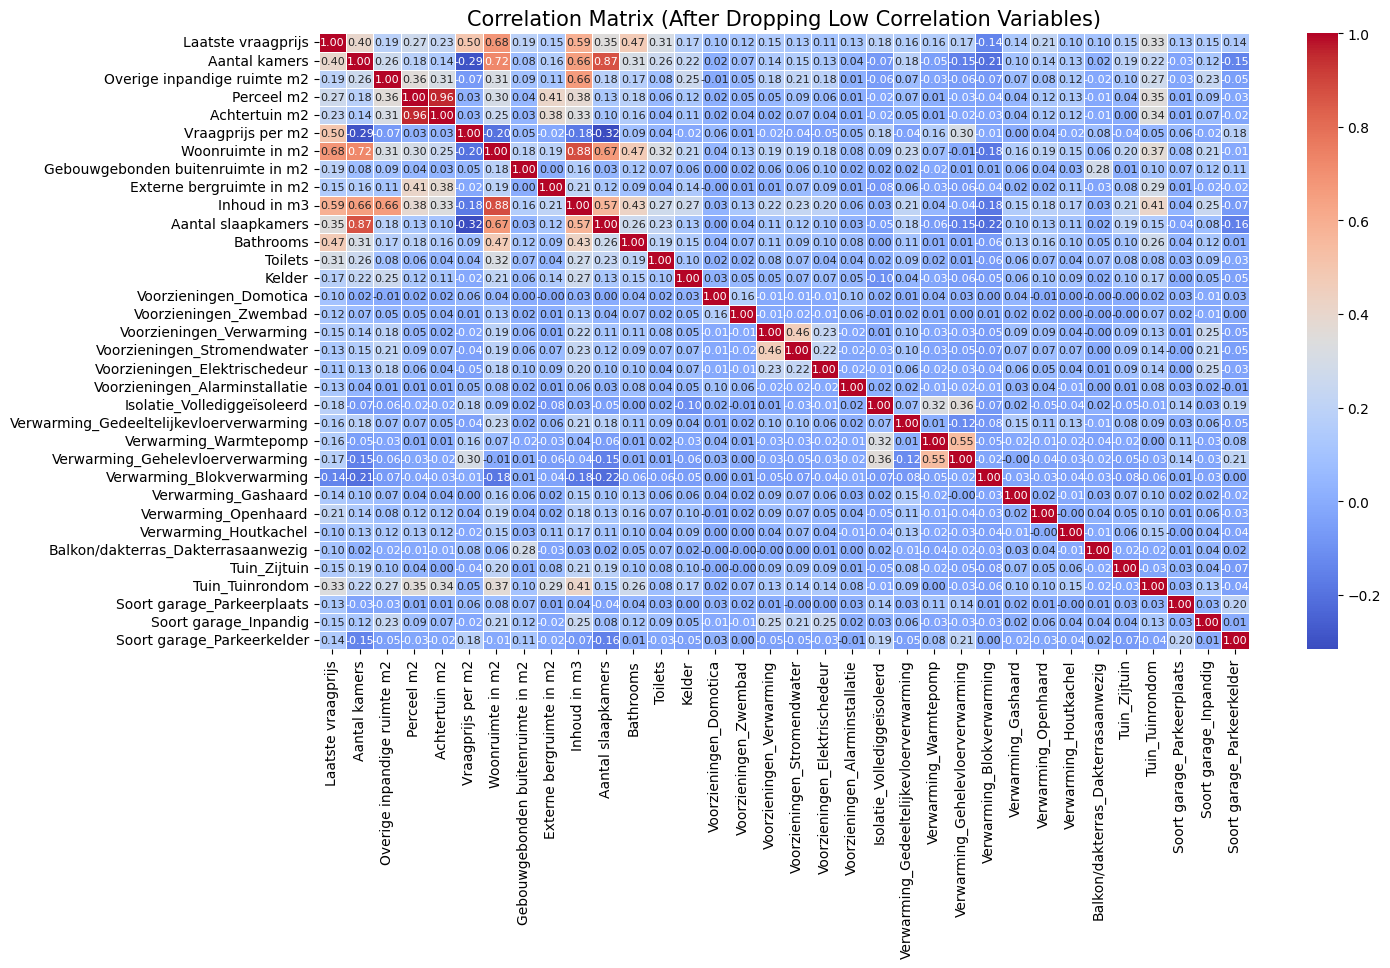

In [ ]:
# Correlation matrix as a heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f", annot_kws={"size": 8})
plt.title('Correlation Matrix (After Dropping Low Correlation Variables)', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


Since our target variable, Last Asking Price was right skewed, it is important to normalize the distribution before building the model, to do that I will apply log transform.

Skewness before log transformation: 2.828123427337964
Skewness after log transformation: 0.5223855107873675


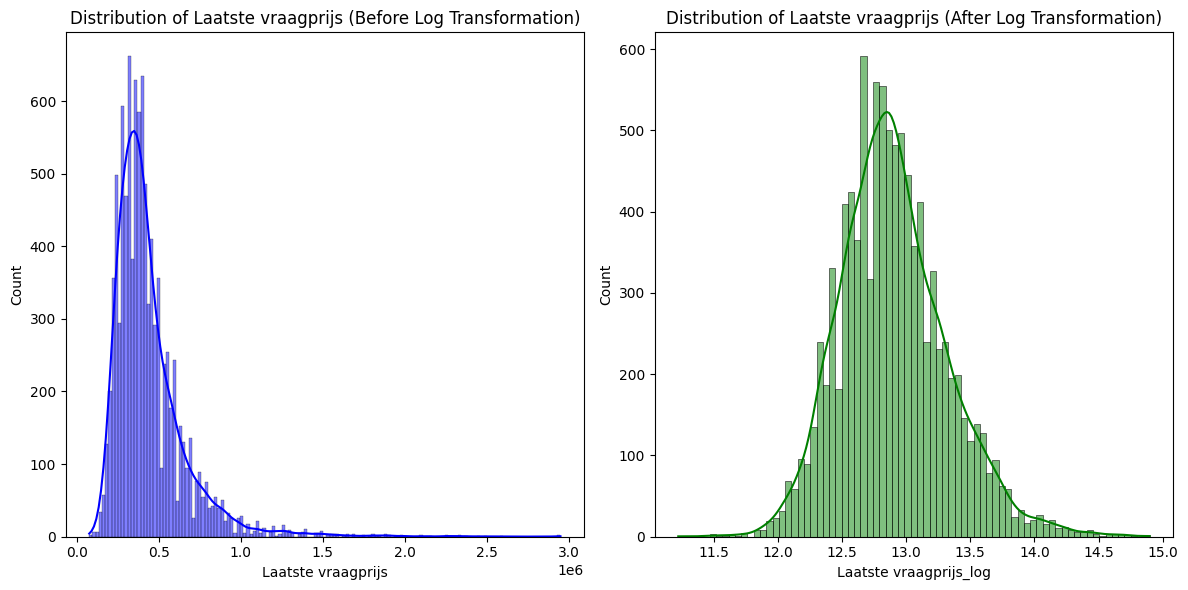

In [ ]:
# Log transformation
data['Laatste vraagprijs_log'] = np.log1p(data['Laatste vraagprijs'].dropna())

# Skewness after log transformation
skewness_after = skew(data['Laatste vraagprijs_log'].dropna())

# Create subplots
plt.figure(figsize=(12, 6))

# Plot distribution before log transformation
plt.subplot(1, 2, 1)
sns.histplot(data['Laatste vraagprijs'].dropna(), kde=True, color='blue')
plt.title(f'Distribution of Laatste vraagprijs (Before Log Transformation)')

# Plot distribution after log transformation
plt.subplot(1, 2, 2)
sns.histplot(data['Laatste vraagprijs_log'].dropna(), kde=True, color='green')
plt.title(f'Distribution of Laatste vraagprijs (After Log Transformation)')

# Print skewness values
print(f"Skewness before log transformation: {skewness_before}")
print(f"Skewness after log transformation: {skewness_after}")

# Adjust layout
plt.tight_layout()
plt.show()

## Developing predictive model with **XGBoost**

Following data cleaning and processing, the next step is modeling. Using the XGBoost algorithm, I've built a regression model to predict the last asking price of properties. The dataset is split into training and testing sets, and the model is trained on the training data. Performance metrics like Mean Squared Error (MSE) and R-squared are computed for both training and testing sets to evaluate model performance. Additionally, cross-validation with 5 folds is performed to assess the model's generalization ability.

For the predictive modeling phase, I reverted to using the original dataset with additional preprocessing steps. These steps included scaling numerical features and encoding categorical features to prepare the data for the machine learning model. This preprocessing ensures that the data fed into the model is in an optimal format for training and prediction.



I start with importing the essential libraries for the machine learning pipeline.

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

Next, I split the dataset into features (X) and the target variable (y), followed by splitting into training and test sets with an 80-20 ratio to ensure proper model evaluation.

In [ ]:
# Split data into features (X) and target variable (y)
X = data.drop(columns=['Laatste vraagprijs'])
y = data['Laatste vraagprijs']

# Split data into full training set and test set
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

This code establishes a preprocessing pipeline to prepare the data for model training. It includes transformers for numerical and categorical features, where missing values are handled appropriately and categorical variables are encoded. The pipeline ensures that both numerical and categorical features are properly processed before being fed into the model.

In [ ]:
# Define your transformers
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Select categorical columns with fewer than 1000 unique values
categorical_col = [col for col in X_train_full.columns if X_train_full[col].dtype == 'O' and X_train_full[col].nunique() < 1000]

# Select numerical columns
numerical_col = [col for col in X_train_full.columns if X_train_full[col].dtype in ['float64', 'int64']]

# Combine selected categorical and numerical columns
my_cols = categorical_col + numerical_col

# Create the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_col),
    ('cat', categorical_transformer, categorical_col)
])

# Define your eval_set_pipe using the preprocessor
eval_set_pipe = Pipeline([
    ('preprocessor', preprocessor)
])

### Model Evaluation

This section of the code trains an XGBoost model on the preprocessed data and evaluates its performance. It involves fitting the preprocessor on the full training set, splitting the transformed data into training and validation sets, training the XGBoost model, making predictions, and evaluating the model's performance using metrics like Mean Squared Error (MSE), R-squared, and performing cross-validation. Finally, it creates a DataFrame to compare actual and predicted values on the test set.

In [ ]:
# Fit the preprocessor on the full training set and transform it
X_train_full_transformed = eval_set_pipe.fit_transform(X_train_full)

# Split the transformed training set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full_transformed, y_train_full, test_size=0.2, random_state=42)

# Define XGBoost model
xgb_model = XGBRegressor()

# Fit model
xgb_model.fit(X_train, y_train)

# Predict
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(eval_set_pipe.transform(X_test))

# Calculate MSE and R-squared for train and test sets
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print("Train MSE:", mse_train)
print("Test MSE:", mse_test)
print("Train R-squared:", r2_train)
print("Test R-squared:", r2_test)

# Perform Cross-Validation
cv_scores = cross_val_score(xgb_model, eval_set_pipe.transform(X), y, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", np.mean(cv_scores))

# Create DataFrame for actual vs predicted values
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test})
print(results)


Train MSE: 2388640.709668943
Test MSE: 180102496.6378745
Train R-squared: 0.9999520760039328
Test R-squared: 0.9963083552184153
Cross-Validation Scores: [0.99344364 0.9956749  0.99712842 0.99035046 0.99100829]
Mean Cross-Validation Score: 0.9935211409950394
      Actual      Predicted
4170  299500  299493.062500
5809  495000  494901.718750
3023  200000  198574.359375
733   399000  399129.687500
8508  242500  240025.078125
...      ...            ...
252   355000  354377.781250
5613  375000  375038.968750
473   295000  295065.812500
6537  539000  539175.125000
5477  339000  339326.000000

[1977 rows x 2 columns]


The model demonstrates strong performance in explaining the variance in house prices, as indicated by high R-squared values. However, the significantly lower MSE on the training set compared to the test set suggests the **possibility of overfitting.** This discrepancy indicates that the model may be fitting too closely to the training data and not generalizing well to new, unseen data points.


## Developing predictive model with **TabNet**



After training and evaluating a conventional ML model like **XGBoost**, it's valuable to compare its performance against the deep learning algorithm **TabNet**. TabNet, a novel deep neural network-based algorithm, is adept at handling tabular data. Notably, it has not been extensively applied for  a house price prediction previously.

This command installs the necessary Python packages pytorch_tabnet, scikit-learn, and pandas which are required for implementing the TabNet algorithm. Lets import the TabNetRegressor class from the pytorch_tabnet library.

In [93]:
!pip install pytorch_tabnet scikit-learn pandas
from pytorch_tabnet.tab_model import TabNetRegressor

**Data Preprocessing:**

I imported libraries for data processing, loaded the dataset, dropped irrelevant columns, removed duplicates, and applied transformations for numerical and categorical features.

**Dataset Splitting and Preprocessing:**

I split the data into training and test sets, preprocessed them using predefined transformers for consistency in feature engineering.

**Model Training with TabNetRegressor:**

I initialized and trained the TabNetRegressor model with specific hyperparameters, evaluating its performance using key metrics on the test set.

**Predictions and Evaluation:**

After training, I made predictions on the test set, transformed them back to the original scale, and calculated evaluation metrics to assess model performance.



In [88]:
# Define your transformers
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Select categorical columns with fewer than 1000 unique values
categorical_col = [col for col in data.columns if data[col].dtype == 'O' and data[col].nunique() < 1000]

# Select numerical columns
numerical_col = [col for col in data.columns if data[col].dtype in ['float64', 'int64']]

# Combine selected categorical and numerical columns
my_cols = categorical_col + numerical_col

# Create the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_col),
    ('cat', categorical_transformer, categorical_col)])

# Define your eval_set_pipe using the preprocessor
eval_set_pipe = Pipeline([
    ('preprocessor', preprocessor)
])

# Selected columns for training
selected_columns = ['Status', 'Soort bouw', 'Energielabel', 'Aantal dagen tot verkoop', 'Soort dak', 'Soort woonhuis',
                     'Laatste vraagprijs', 'Aantal kamers', 'Overige inpandige ruimte m2', 'Perceel m2', 'Achtertuin m2',
                     'Vraagprijs per m2', 'Woonruimte in m2', 'Gebouwgebonden buitenruimte in m2', 'Externe bergruimte in m2',
                     'Inhoud in m3', 'Aantal slaapkamers', 'Bathrooms', 'Toilets', 'Kelder', 'Voorzieningen_Domotica',
                     'Voorzieningen_Zwembad', 'Voorzieningen_Verwarming', 'Voorzieningen_Stromendwater', 'Voorzieningen_Elektrischedeur',
                     'Voorzieningen_Alarminstallatie', 'Isolatie_Vollediggeïsoleerd', 'Verwarming_Gedeeltelijkevloerverwarming',
                     'Verwarming_Warmtepomp', 'Verwarming_Gehelevloerverwarming', 'Verwarming_Blokverwarming', 'Verwarming_Gashaard',
                     'Verwarming_Openhaard', 'Verwarming_Houtkachel', 'Balkon/dakterras_Dakterrasaanwezig', 'Tuin_Zijtuin',
                     'Tuin_Tuinrondom', 'Soort garage_Parkeerplaats', 'Soort garage_Inpandig', 'Soort garage_Parkeerkelder']

selected_data = data[selected_columns]

X = data.drop('Laatste vraagprijs', axis=1)
y = data['Laatste vraagprijs']
y_log = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Assuming you have categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Create transformers for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Applying the transformations
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Initialize TabNetRegressor with adjusted hyperparameters
regressor = TabNetRegressor(
    n_d=16,
    n_a=16,
    n_steps=5,
    gamma=1.3,
    lambda_sparse=0.001,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax',
    scheduler_params=dict(max_lr=0.05, steps_per_epoch=100, epochs=20),
)

# Train the model
regressor.fit(
    X_train_preprocessed, y_train.values.reshape(-1, 1),
    eval_set=[(X_test_preprocessed, y_test.values.reshape(-1, 1))],
    max_epochs=100,
    eval_metric=['mae', 'mse', 'rmse']
)

# Make predictions on the test set
y_test_pred_tabnet = regressor.predict(X_test_preprocessed)

# Calculate metrics on the original scale
y_test_pred_original_scale = np.expm1(y_test_pred_tabnet)
y_test_original_scale = np.expm1(y_test)

mae = mean_absolute_error(y_test_original_scale, y_test_pred_original_scale)
mse = mean_squared_error(y_test_original_scale, y_test_pred_original_scale)
r2 = r2_score(y_test_original_scale, y_test_pred_original_scale)

print("TabNet - MAE:", mae, "MSE:", mse, "R2 Score:", r2)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 78.55505| val_0_mae: 9.09124 | val_0_mse: 82.8391 | val_0_rmse: 9.1016  |  0:00:11s
epoch 1  | loss: 34.11521| val_0_mae: 4.42675 | val_0_mse: 20.07434| val_0_rmse: 4.48044 |  0:00:17s
epoch 2  | loss: 17.13768| val_0_mae: 3.45747 | val_0_mse: 12.50138| val_0_rmse: 3.53573 |  0:00:22s
epoch 3  | loss: 5.73318 | val_0_mae: 1.55398 | val_0_mse: 2.86782 | val_0_rmse: 1.69347 |  0:00:28s
epoch 4  | loss: 2.32529 | val_0_mae: 0.63602 | val_0_mse: 0.67415 | val_0_rmse: 0.82106 |  0:00:34s
epoch 5  | loss: 1.29402 | val_0_mae: 0.74032 | val_0_mse: 0.78541 | val_0_rmse: 0.88623 |  0:00:40s
epoch 6  | loss: 0.89168 | val_0_mae: 0.82204 | val_0_mse: 0.88859 | val_0_rmse: 0.94265 |  0:00:45s
epoch 7  | loss: 0.81365 | val_0_mae: 0.89917 | val_0_mse: 1.00975 | val_0_rmse: 1.00486 |  0:00:50s
epoch 8  | loss: 0.6698  | val_0_mae: 0.47248 | val_0_mse: 0.36651 | val_0_rmse: 0.6054  |  0:00:56s
epoch 9  | loss: 0.53149 | val_0_mae: 0.34312 | val_0_mse: 0.20364 | val_0_rmse: 0.45126 | 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet - MAE: 46845.47655458862 MSE: 8937492281.422459 R2 Score: 0.8240516822704684


## Result discussion

The slightly lower R2 (0.82) score with the TabNet compared to XGBoost could be caused by several factors. TabNet is a DNN, which requires a different preprocessing approach compared to XGBoost. Despite following the same preprocessing method, the complexity of DNNs might demand more specialized preprocessing techniques.

Additionally, the architecture and learning dynamics of TabNet and XGBoost differ significantly. XGBoost operates as an ensemble of decision trees, while TabNet utilizes a deep learning architecture with attention mechanisms.

Nevertheless, achieving a respectable R2 score of 0.82 with TabNet suggests that it still performs well overall.Fine-tuning preprocessing techniques and hyperparameters specifically tailored to TabNet's architecture may further enhance its performance and bridge any performance gap compared to XGBoost.